## Calculation of scores

This notebook includes calculations for the QED, NP, Böttcher, and nSPS scores.

In [1]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from pandarallel import pandarallel
from rdkit.Chem import PandasTools, QED, SpacialScore

In [2]:
# Add path to RDKit contributions
# taken from https://github.com/rdkit/rdkit/issues/2279
import sys
from rdkit.Chem import RDConfig

sys.path.append(RDConfig.RDContribDir)

from NP_Score import npscorer

The Böttcher score was calculated using the implementation from the Forli group. A clone of the original [repo](https://github.com/forlilab/bottchscore/tree/master) was used for it.

In [3]:
# add path to Böttcher repo
BASE_PATH = Path.cwd().parent
bottcher_path = BASE_PATH.parent.parent / "Downloads" / "bottchscore"

sys.path.append(str(bottcher_path))

from bottchscore3 import calculate_bottchscore_from_smiles

In [4]:
fscore = npscorer.readNPModel()
def score_np(mol):
    return npscorer.scoreMol(mol, fscore)

reading NP model ...
model in


In [5]:
def get_scores(filepath):
    df = pd.read_csv(filepath)
    # if any(x in file for x in ["chembl", "drugbank"]):
    #     df = df.sample(n=5000, random_state=2025)
    smi_col = df.columns[df.columns.str.contains("smiles")][0]
    PandasTools.AddMoleculeColumnToFrame(df, smilesCol=smi_col)

    if len(df) > 1000:
        pandarallel.initialize(nb_workers=24, progress_bar=True)
        df["NP_likeness"] = df["ROMol"].parallel_apply(score_np)
        df["QED"] = df["ROMol"].parallel_apply(QED.default)
        df["Boettcher"] = df[smi_col].parallel_apply(calculate_bottchscore_from_smiles)
        df["nSPS"] = df["ROMol"].parallel_apply(SpacialScore.SPS)
    else:
        df["NP_likeness"] = df["ROMol"].apply(score_np)
        df["QED"] = df["ROMol"].apply(QED.default)
        df["Boettcher"] = df[smi_col].apply(calculate_bottchscore_from_smiles)
        df["nSPS"] = df["ROMol"].apply(SpacialScore.SPS)
    cols = [df.columns[0]] + ["NP_likeness", "QED", "Boettcher", "nSPS"]
    return df[cols]


In [6]:
files = [f for f in Path.iterdir(BASE_PATH / "data" / "processed")
         if "cleaned.csv" in f.name]
files.append(BASE_PATH / "data" / "interim" / "Sceletium_compounds.csv")
files

[PosixPath('/home/f.bernal/Documents/2025_greiner_pseudo-np/data/processed/chembl_35_NP_cleaned.csv'),
 PosixPath('/home/f.bernal/Documents/2025_greiner_pseudo-np/data/processed/pseudo_NPs_cleaned.csv'),
 PosixPath('/home/f.bernal/Documents/2025_greiner_pseudo-np/data/processed/enamine_advanced_50k_subset_cleaned.csv'),
 PosixPath('/home/f.bernal/Documents/2025_greiner_pseudo-np/data/processed/Hasubanan_cleaned.csv'),
 PosixPath('/home/f.bernal/Documents/2025_greiner_pseudo-np/data/processed/drugbank_5_1_13_cleaned.csv'),
 PosixPath('/home/f.bernal/Documents/2025_greiner_pseudo-np/data/interim/Sceletium_compounds.csv')]

In [7]:
start = time.time()
scores = []
for file in files:
    name = file.name.split("_")[0]
    if name == "pseudo":
        name = "pseudoNPs"
    df = get_scores(file)
    df.insert(1, "dataset", [name] * len(df))
    df.rename(columns={df.columns[0]: "ID"}, inplace=True)
    scores.append(df)

scores = pd.concat(scores, axis=0)
end = time.time()

print(f"Total execution time: {end - start :.2f} s")

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...


INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...
*** Open Babel Error  in operator()
  memory limit exceeded...


Total execution time: 74.83 s


In [8]:
scores.head()

,ID,dataset,NP_likeness,QED,Boettcher,nSPS
0,CHEMBL1000,chembl,-1.211237,0.703894,233.323972,16.925926
1,CHEMBL100014,chembl,0.394408,0.515597,128.019550,10.857143
2,CHEMBL100042,chembl,0.512067,0.389670,445.242318,23.121212
3,CHEMBL100109,chembl,-0.164178,0.232197,375.990693,17.677419
4,CHEMBL100116,chembl,1.749172,0.833526,203.555631,31.619048


In [9]:
scores.shape

(139604, 6)

In [10]:
scores.to_csv(BASE_PATH / "reports" / "scores.csv", index=False)

In [11]:
order = {}
for name, group in scores.groupby("dataset"):
    l = scores.dataset.apply(len).max() + 1
    print(f"{name :10}: {len(group)}")
    order[name] = len(group)

order = {k: v for k, v in sorted(order.items(), key=lambda item: item[1], reverse=True)}

Hasubanan : 118
Sceletium : 15
chembl    : 78163
drugbank  : 11307
enamine   : 49974
pseudoNPs : 27


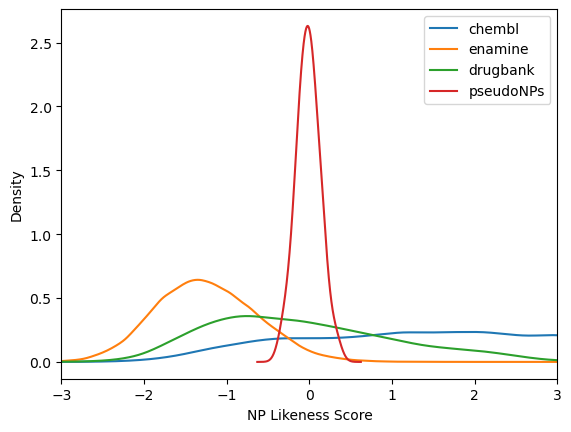

In [12]:
fig = plt.figure()
for data in order.keys():
    if data not in ["Sceletium", "Hasubanan"]:
        scores.query("dataset == @data")["NP_likeness"].plot.density(label=data)

plt.xlabel("NP Likeness Score")
plt.xlim((-3,3))
plt.legend()
plt.show()

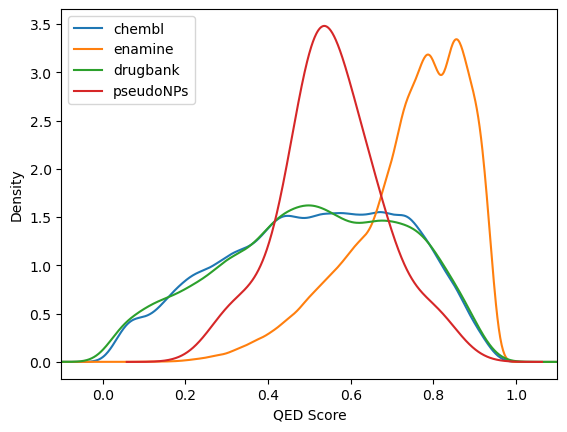

In [13]:
fig = plt.figure()
for data in order.keys():
    if data not in ["Sceletium", "Hasubanan"]:
        scores.query("dataset == @data")["QED"].plot.density(label=data)

plt.xlabel("QED Score")
plt.xlim((-0.1,1.1))
plt.legend()
plt.show()

In [14]:
scores["Boettcher"].max()

np.float64(1688.252675333174)

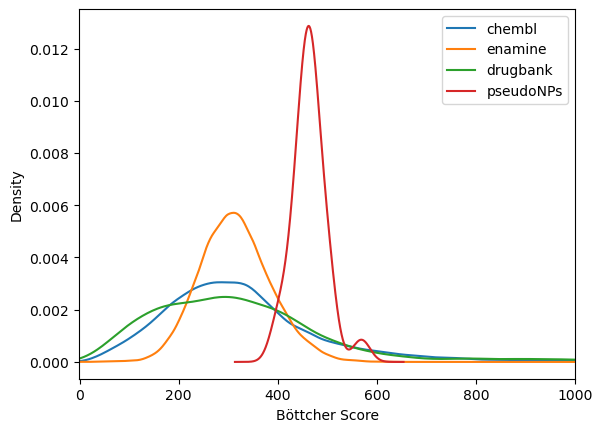

In [15]:
fig = plt.figure()
for data in order.keys():
    if data not in ["Sceletium", "Hasubanan"]:
        scores.query("dataset == @data")["Boettcher"].plot.density(label=data)

plt.xlabel("Böttcher Score")
plt.xlim((-1, 1000))
plt.legend()
plt.show()

In [16]:
scores["nSPS"].max()

np.float64(80.18181818181819)

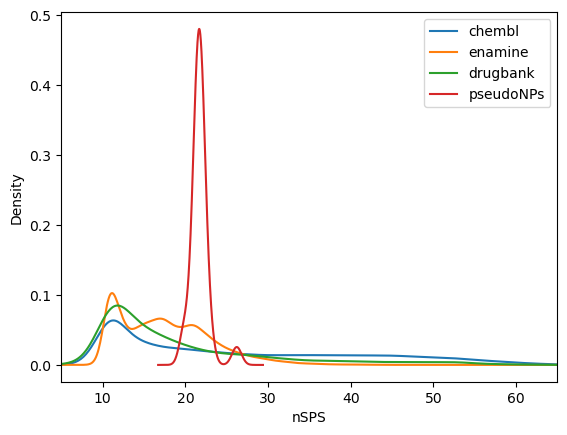

In [17]:
fig = plt.figure()
for data in order.keys():
    if data not in ["Sceletium", "Hasubanan"]:
        scores.query("dataset == @data")["nSPS"].plot.density(label=data)

plt.xlabel("nSPS")
plt.xlim((5, 65))
plt.legend()
plt.show()

In [18]:
comparisons = scores.query("dataset in ['pseudoNPs', 'Sceletium', 'Hasubanan']").copy()
comparisons["new_set"] = comparisons["dataset"]
print(comparisons.shape[0])
for file in ["Amaryllidaceae.csv", "MIAs.csv"]:
    idx = pd.read_csv(BASE_PATH / "data" / file)
    tmp = scores.query("ID in @idx['chembl_id']").copy()
    tmp["new_set"] = file.split(".")[0]
    comparisons = pd.concat((comparisons, tmp), axis=0)
    print(comparisons.shape[0])


160
267
1316


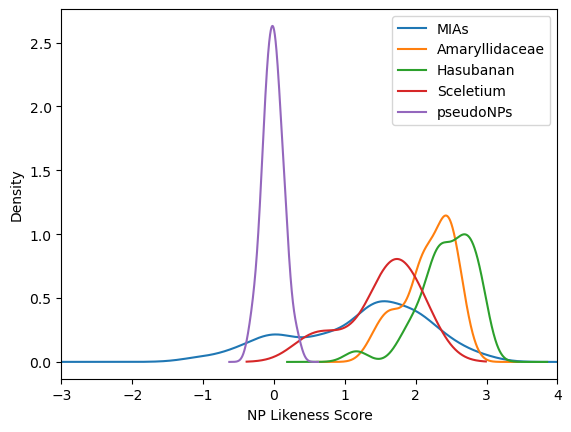

In [20]:
fig = plt.figure()
for data in ["MIAs", "Amaryllidaceae", "Hasubanan", "Sceletium", "pseudoNPs"]:
    comparisons.query("new_set == @data")["NP_likeness"].plot.density(label=data)

plt.xlabel("NP Likeness Score")
plt.xlim((-3,4))
plt.legend()
plt.show()

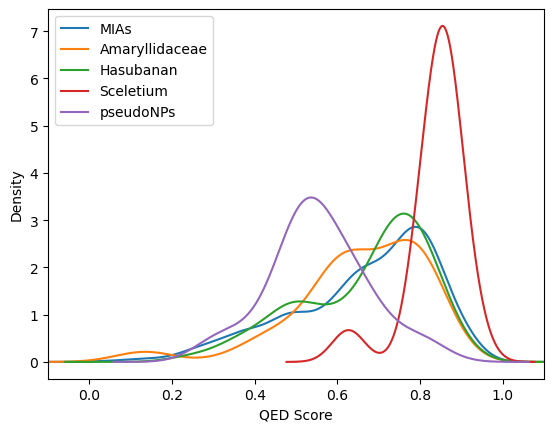

In [21]:
fig = plt.figure()
for data in ["MIAs", "Amaryllidaceae", "Hasubanan", "Sceletium", "pseudoNPs"]:
    comparisons.query("new_set == @data")["QED"].plot.density(label=data)

plt.xlabel("QED Score")
plt.xlim((-0.1,1.1))
plt.legend()
plt.show()

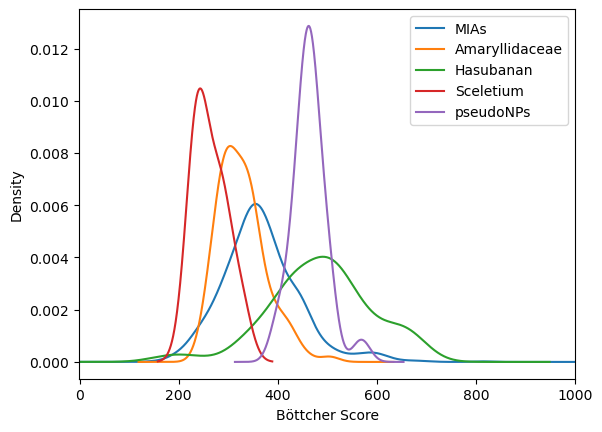

In [22]:
fig = plt.figure()
for data in ["MIAs", "Amaryllidaceae", "Hasubanan", "Sceletium", "pseudoNPs"]:
    comparisons.query("new_set == @data")["Boettcher"].plot.density(label=data)

plt.xlabel("Böttcher Score")
plt.xlim((-1, 1000))
plt.legend()
plt.show()

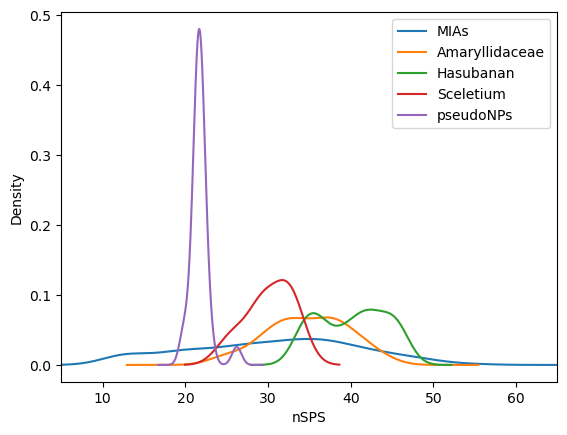

In [23]:
fig = plt.figure()
for data in ["MIAs", "Amaryllidaceae", "Hasubanan", "Sceletium", "pseudoNPs"]:
    comparisons.query("new_set == @data")["nSPS"].plot.density(label=data)

plt.xlabel("nSPS")
plt.xlim((5, 65))
plt.legend()
plt.show()

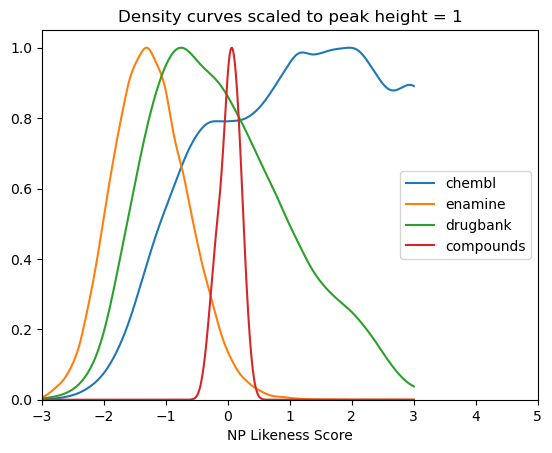

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

x_vals = np.linspace(-3, 3, 500)

fig = plt.figure()

for data in order.keys():
    values = scores.query("dataset == @data")["NP_likeness"].dropna()
    kde = gaussian_kde(values)
    y = kde(x_vals)
    y_scaled = y / y.max()  # scale so the max y-value becomes 1
    plt.plot(x_vals, y_scaled, label=data)

plt.xlabel("NP Likeness Score")
plt.xlim((-3, 5))
plt.ylim(0, 1.05)  # All curves now peak at 1
plt.legend()
plt.title("Density curves scaled to peak height = 1")
plt.show()
